In [253]:
#!/usr/bin/env python3
import argparse
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
# from datetime import datetime
# from zoneinfo import ZoneInfo

from typing import Union, LiteralString, List, Set
import pandas as pd

In [202]:
FileName = Union[LiteralString, str]
Numeric = Union[int, float]
DEBUG: bool = False
VERBOSE: bool = False

In [ ]:
class ExtractClusterData:

    def __init__(
                self, 
                 data: Union[pd.DataFrame, FileName], 
                 is_offline: bool = True,
                 number_cluster_vars: int = 6,
                 perform_smoothen: bool = False
                 ) -> None:
        
        # Attributes
        self.is_offline: bool = is_offline
        self.number_cluster_vars: int = number_cluster_vars
        self.perform_smoothen: bool = perform_smoothen

        # Create Panda Frame
        self.data = self.create_panda_dataframe(data)

        # Start and End indices
        self.start: int = 0
        self.end: int = self.data.size

        # Figs
        self.figs: Dict[int, plt.Fig] = dict()

        self.define_col_headers()    
    
    def define_col_headers(self) -> None:
        
        # For each column in the data frame
        for c in self.data.columns:

            # Create a class attribute and assign the column
            # NOTE: The .strip() method removes leading and trailing
            # whitespace.
            # NOTE: The .replace(' ', '_') replaces inner spaces with
            # underscores
            self.__setattr__(c.strip().replace(' ', '_'), self.data[c])

        # Prints all the keys
        if VERBOSE: print(self.__dict__.keys())  

    def smoothen() -> None:
        pass

    @staticmethod
    # NOTE: From `https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot`
    def add_arrow(line, position=None, direction='right', size=15, color=None):
        """
        add an arrow to a line.

        line:       Line2D object
        position:   x-position of the arrow. If None, mean of xdata is taken
        direction:  'left' or 'right'
        size:       size of the arrow in fontsize points
        color:      if None, line color is taken.
        """
        if color is None:
            color = line.get_color()

        xdata = line.get_xdata()
        ydata = line.get_ydata()

        if position is None:
            position = xdata.mean()
        # find closest index
        start_ind = np.argmin(np.absolute(xdata - position))
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1

        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="->", color=color),
            size=size
        )

    # NOTE: Got from ChatGPT
    @staticmethod
    def add_arrows_to_line(line, n_arrows=20, arrow_style='->', color=None, size=15, spacing='data', ind_spacing=10):
        """
        Adds arrows to a matplotlib Line2D object to indicate direction.

        Parameters:
        - line        : matplotlib Line2D object (e.g. from ax.plot)
        - n_arrows    : number of arrows to draw
        - arrow_style : arrow style (e.g., '->', '-|>')
        - color       : arrow color (defaults to line color)
        - size        : arrow size
        - spacing     : 'data' or 'index' based spacing
        """
        import numpy as np
        import matplotlib.pyplot as plt

        x = np.array(line.get_xdata())
        y = np.array(line.get_ydata())
        ax = line.axes  # get the Axes the line belongs to

        if color is None:
            color = line.get_color()

        if spacing == 'data':
            dist = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
            dist = np.insert(dist, 0, 0)
            arrow_locs = np.linspace(0, dist[-1], n_arrows + 2)[1:-1]
            arrow_indices = [np.searchsorted(dist, loc) for loc in arrow_locs]
        else:
            arrow_indices = np.linspace(1, len(x)-2, n_arrows).astype(int)

        s = ind_spacing//2
        for i in arrow_indices:
            dx = x[i+s] - x[i-s]
            dy = y[i+s] - y[i-s]
            ax.annotate('', xy=(x[i+s], y[i+s]), xytext=(x[i-s], y[i-s]),
                        arrowprops=dict(arrowstyle=arrow_style, color=color),
                        size=size)

    def _get_fig(self,
                i, 
                start: int, 
                end: int, 
                x: pd.DataFrame,
                y: pd.DataFrame,
                use_arrows: bool = False,
                *args,
                **kwargs
                ) -> plt.Figure:
        
        # Plot line
        fig = plt.figure(i)
        line = plt.plot(x[start:end], y[start:end], *args, **kwargs)[0]
        
        # Add arrows if desired
        if use_arrows: self.add_arrows_to_line(line)
        
        # Add figure to figs
        self.figs[i] = fig

        return fig

    
    def _get_time_domain_fig(
                            self,
                            i, 
                            start: int, 
                            end: int, 
                            y: pd.DataFrame,
                            *args,
                            **kwargs
                            ) -> plt.Figure:

        return self._get_fig(i, start, end, self.timestamp, y, *args, **kwargs)
    

    def get_time_domain_figs(self) -> List[plt.Figure]:

        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        cluster_vars: Dict[int, List[pd.DataFrame]] = \
            {
             1: [self.x_c_des, self.x_c],
             2: [self.y_c_des, self.y_c],
             3: [self.t_c_des, self.t_c],
             4: [self.p_des, self.p],
             5: [self.q_des, self.q],
             6: [self.B_des, self.B],
             }
        
        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        theta_rstr: str = '\theta'
        title_vars: Dict[int, List[str]] = \
            {
                1: ["Time history of X-position of centroid $x_c$",
                   "X-Position of centroid $x_c$ (m)"],
                2: ["Time history of Y-position of centroid $y_c$",
                   "Y-Position of centroid $y_c$ (m)"],
                3: ["Time history of heading of centroid $\\theta_c$",
                   f"Heading of centroid $\\theta_c$ (rad)"],
                4: ["Time history of $p$-length of cluster configuration",
                   "Length of $p$ (m)"],
                5: ["Time history of $q$-length of cluster configuration",
                   "Length of $q$ (m)"],
                6: ["Time history of $B$-angle of cluster configuration",
                   "Angle of $B$ (rad)"]
            }


        # Initialize empty list of 6 length
        figs: list = [None] * len(cluster_vars.keys())
        if DEBUG: print(len(figs))

        for k, list_values in cluster_vars.items():
            if DEBUG: print(k)
            for v in list_values:
                figs[k - 1] = \
                    self._get_time_domain_fig(
                    k,
                    self.start,
                    self.end,
                    v,
                    )
                plt.title(title_vars[k][0])
                plt.xlabel("Time history (s)")
                plt.ylabel(title_vars[k][1])
                plt.legend(["Desired", "Actual"])
                plt.grid(True)
        return figs
           
    def get_centroid_phase_portrait(
                           self,
                           ind: int,
                           start: int,
                           end: int
                           ) -> plt.Figure:

        fig = self._get_fig(ind, start, end, self.x_c_des, self.y_c_des, use_arrows= True, color="blue")
        fig = self._get_fig(ind, start, end, self.x_c, self.y_c, use_arrows= True, color="green")
        plt.title("Phase portrait of cluster centroid")
        plt.xlabel("X-position of cluster centroid $x_c$ (m)")
        plt.ylabel("Y-position of cluster centroid $y_c$ (m)")
        plt.legend(["Desired", "Actual"])
        plt.grid(True)
        plt.axis('equal')

        return fig

    @staticmethod
    def annotate_polygon(
                        ind: int,
                        x: List[Numeric],
                        y: List[Numeric],
                        *args,
                        **kwargs 
                        ) -> plt.Figure:
        
        # If x and y do not match length
        if len(x) != len(y):
            raise("Incorrect size")

        fig = plt.figure(ind)

        # Plot triangle
        plt.plot(x, y, *args, **kwargs)

        colors: List[str] = ["red", "blue", "green", "orange", "purple"]
        # Add vertices
        for i in range(len(x)):

            plt.scatter(x[i], y[i], color=colors[i % len(x) - 1])

        plt.axis('equal')
        
        return fig
        

    def get_cluster_phase_portrait(
                          self,
                           ind: int,
                           start: int,
                           end: int
                           ) -> plt.Figure:
        
        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        xy_pos: Dict[int, List[pd.DataFrame]] = \
            {1: [self.x_1, self.y_1],
             2: [self.x_2, self.y_2],
             3: [self.x_3, self.y_3]}
        
        
        for _, v in xy_pos.items():
            fig = \
                self._get_fig(
                ind,
                start,
                end,
                v[0],
                v[1],
                use_arrows= True
                )

        plt.title("Phase portrait of 3-cluster configuration of robots")
        plt.xlabel("X-position $x$ (m)")
        plt.ylabel("Y-position $y$ (m)")
        # TODO: Fix hardcoded number of robots
        plt.legend([f"Robot {i}, $r_{i}$" for i in range(1,4)])
        plt.grid(True)


        # TODO: Can these endpoints be implemented within the annotate_polygon() 
        # instead
        # Creating the points of the cluster config
        x_endpoints: List[Numeric] = [v[0][end] for _, v in xy_pos.items()]
        y_endpoints: List[Numeric] = [v[1][end] for _, v in xy_pos.items()]

        # Adding the first point again to the end to close the polygon
        x_endpoints.append(x_endpoints[0])
        y_endpoints.append(y_endpoints[0])

        if DEBUG:
            print(x_endpoints)
            print(y_endpoints)

        fig = self.annotate_polygon(ind, x_endpoints, y_endpoints, color="blue")

        # Creating the points of the cluster config
        x_startpoints: List[Numeric] = [v[0][start] for _, v in xy_pos.items()]
        y_startpoints: List[Numeric] = [v[1][start] for _, v in xy_pos.items()]

        # Adding the first point again to the end to close the polygon
        x_startpoints.append(x_startpoints[0])
        y_startpoints.append(y_startpoints[0])

        fig = self.annotate_polygon(ind, x_startpoints, y_startpoints, color="blue")

        return fig

    # TODO: Add histogram plot
    def get_sensor_histogram_plot() -> plt.Figure:
        pass

    def export_figs(self, dirname: FileName = "figures") -> bool:

        try:
            
            # If the directory already exists, delete it
            if os.path.exists(dirname):
                shutil.rmtree(dirname) 
            
            # Create directory
            os.makedirs(dirname, exist_ok=True)

            for k, fig in self.figs.items():

                # Get current axis
                ax = fig.axes[0]

                # Extract title and replace name
                file_name: str = ax.get_title() \
                                        .lower() \
                                        .replace(' ', '_') \
                                        .replace('$', '') \
                                        .replace('\\','') 
                if VERBOSE: print(f"Filename: {file_name}")
                
                fig.savefig(os.path.join(dirname,file_name + ".png"))
                if VERBOSE: print("Saved figure!")

        except Exception as e:
            print(f"Error: {e}")
            return False
        return True
        


    @staticmethod
    def create_panda_dataframe(data) -> pd.DataFrame:
        
        # Get datatype
        typ = type(data)

        # TODO: Check which type of string
        if typ == str or typ == LiteralString:
            return pd.read_csv(data)
        elif typ == pd.DataFrame:
            return data           

/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_5967/1661400667.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figs[f].show()
/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_5967/1661400667.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  phase_portrait.show()
/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_5967/1661400667.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  cluster_phase_portrait.show()


1
2
3
4
5
6
7
8


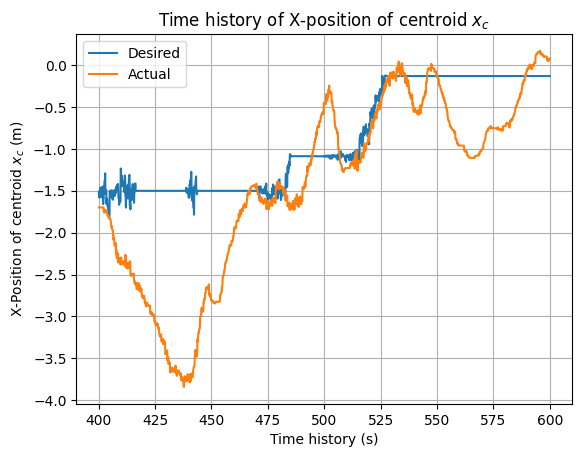

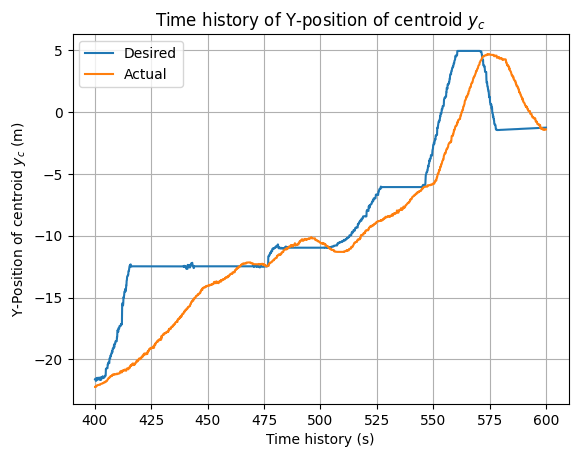

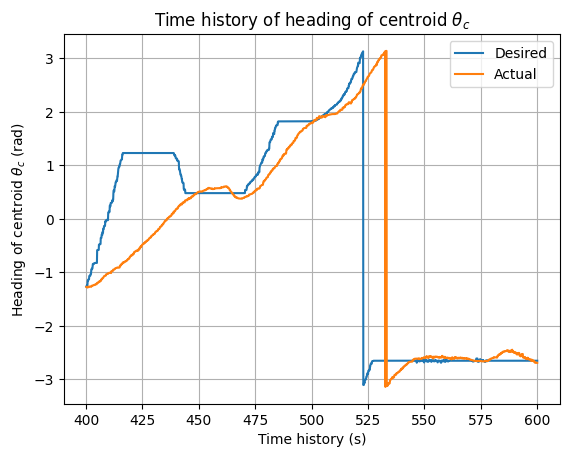

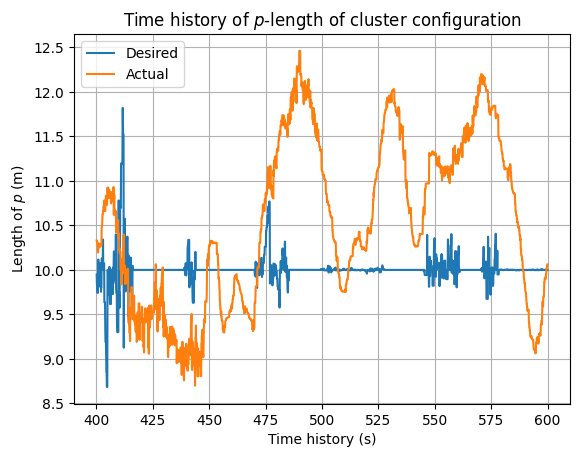

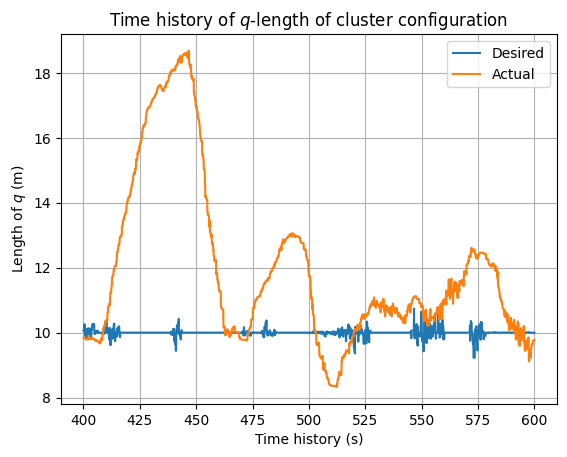

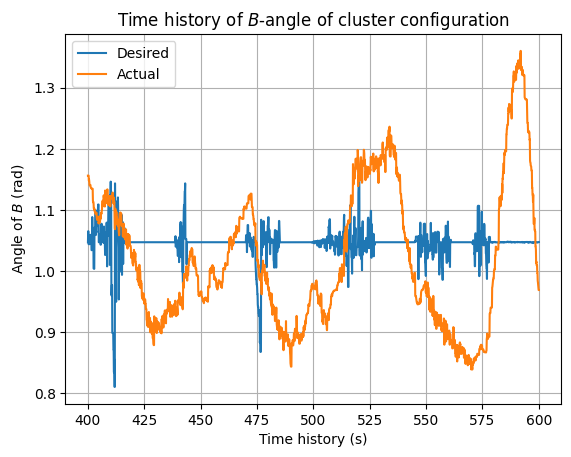

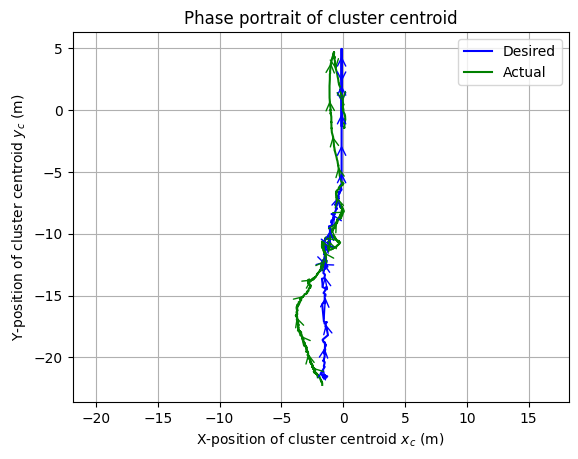

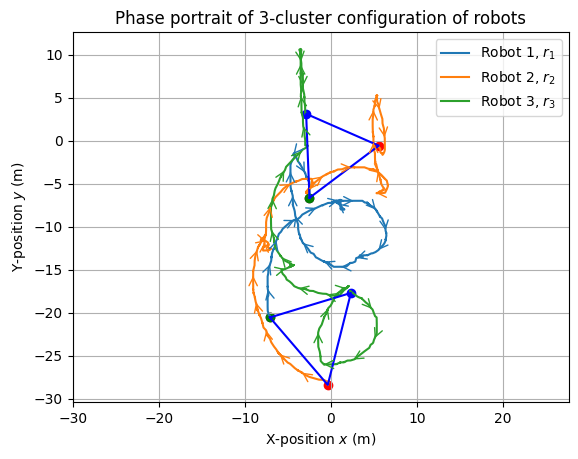

In [ ]:
def main2():
    
    grapher: ExtractClusterData = ExtractClusterData(
        "TestData_with_Timestamp.csv",
    )

    # TODO: Make this more customizeable
    # TODO: Identify time sections that are relevant
    #       Idea: Make Histogram of when x_1_des is being used to identify when it's being used!
    grapher.start = 4000
    grapher.end = 6000

    # Plot time domain graphs
    figs: List[plt.Figure] = grapher.get_time_domain_figs()
    for f in range(len(figs)):
        figs[f].show()

    # Plot centroid phase portrait
    phase_portrait: plt.Figure = \
            grapher.get_centroid_phase_portrait(
                                        ind=7,
                                        start=grapher.start,
                                        end=grapher.end
                                        )
    phase_portrait.show()

    # Plot cluster phase portrait
    cluster_phase_portrait: plt.Figure = \
            grapher.get_cluster_phase_portrait(
                ind=8,
                start=grapher.start,
                end=grapher.end
            )
    cluster_phase_portrait.show()

    # Export figures
    grapher.export_figs(f"figures_{grapher.start}_to_{grapher.end}")

if __name__ == "__main__":
    main2()

In [ ]:
os.mkdir()